In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from gen_data import gen_data # gets the data for this project

In [2]:
RNNconfig = {
    'num_steps' : 5,
    'batch_size' : 200,
    'state_size' :1,
    'learning_rate' : 0.1
}

def set_config(new_config):
    assert isinstance(new_config, dict), "arg must be dict" 
    if 'num_steps' in list(new_config.keys()):
        RNNconfig['num_steps'] = new_config['num_steps']
    if 'batch_size' in list(new_config.keys()):
        RNNconfig['batch_size'] = new_config['batch_size']
    if 'state_size' in list(new_config.keys()):
        RNNconfig['state_size'] = new_config['state_size']
    if 'learning_rate' in list(new_config.keys()):
        RNNconfig['learning_rate'] = new_config['learning_rate']
    for k, v in list(RNNconfig.items()):
        print("{} : {}".format(k, v))




num_steps = 5
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

In [3]:
# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps) # python trivia: why do we use yield instead of return here?

In [4]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [RNNconfig['batch_size'], RNNconfig['num_steps']], name='input_placeholder')
y = tf.placeholder(tf.int32, [RNNconfig['batch_size'], RNNconfig['num_steps']], name='labels_placeholder')
init_state = tf.zeros([RNNconfig['batch_size'], RNNconfig['state_size']])

"""
RNN Inputs
"""

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
x_one_hot = tf.one_hot(x, num_classes) # note: num_classes is not an RNN variable...
rnn_inputs = tf.unstack(x_one_hot, axis=1)

In [5]:
"""
from __call__ method
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/rnn_cell.py
"""
with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + RNNconfig['state_size'], RNNconfig['state_size']])
    b = tf.get_variable('b', [RNNconfig['state_size']], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + RNNconfig['state_size'], RNNconfig['state_size']])
        b = tf.get_variable('b', [RNNconfig['state_size']], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

In [6]:
"""
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/rnn_cell.py
"""
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

In [7]:
"""
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
"""

#logits and predictions
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [RNNconfig['state_size'], num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# Turn our y placeholder into a list of labels
y_as_list = tf.unstack(y, num=num_steps, axis=1)

#losses and train_step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [8]:

def train_network(num_epochs, verbose=True):
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, RNNconfig['num_steps'])):
            training_loss = 0
            training_state = np.zeros((RNNconfig['batch_size'], RNNconfig['state_size']))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 100 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses


EPOCH 0
Average loss at step 100 for last 100 steps: 0.669509993792
Average loss at step 200 for last 100 steps: 0.661844434142
Average loss at step 300 for last 100 steps: 0.661094458699
Average loss at step 400 for last 100 steps: 0.661340853572
Average loss at step 500 for last 100 steps: 0.661560095549
Average loss at step 600 for last 100 steps: 0.661784843206
Average loss at step 700 for last 100 steps: 0.661147184968
Average loss at step 800 for last 100 steps: 0.661213169098
Average loss at step 900 for last 100 steps: 0.661346476674

EPOCH 1
Average loss at step 100 for last 100 steps: 0.668405897617
Average loss at step 200 for last 100 steps: 0.662129837871
Average loss at step 300 for last 100 steps: 0.662050071955
Average loss at step 400 for last 100 steps: 0.662160313725
Average loss at step 500 for last 100 steps: 0.661250349283
Average loss at step 600 for last 100 steps: 0.660910141468
Average loss at step 700 for last 100 steps: 0.662697259188
Average loss at step 8

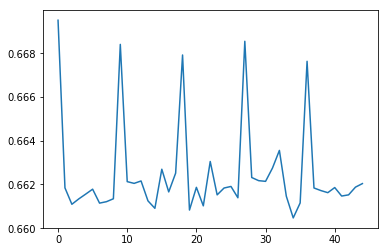

In [9]:

training_losses = train_network(num_epochs = 5)
plt.plot(training_losses)

### Sources (and additional links for reading): 

1. https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html
2. http://karpathy.github.io/2015/05/21/rnn-effectiveness/
3. http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/